Marcin Wardyński  
wtorek, 9:45

## Laboratorium 7
### 7.4 AE


#### Funkcje pomocnicze

In [15]:
import warnings
warnings.filterwarnings("ignore")

import importlib
import lab7_utils as utils
importlib.reload(utils)

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 42

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt

class FrozenEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.encoder.predict(X)
    
    
def viz_score_to_latent_dim(latent_dims, scores_1, scores_2, metric_name, score_1_name, score_2_name):

    plt.figure(figsize=(8, 5))
    plt.plot(latent_dims, scores_1, label=score_1_name, color="red", linestyle="-", marker="o")
    if scores_2:
        plt.plot(latent_dims, scores_2, label=score_2_name, color="blue", linestyle="-", marker="o")
    plt.title(f"{metric_name} - Lattent Layer Dimension")
    plt.xlabel("Lattent Layer Dimension")
    plt.ylabel(f"{metric_name}")
    plt.legend()
    plt.show()

    for i in range(len(latent_dims)):
        print(f"[{latent_dims[i]} -> {score_1_name}: {scores_1[i]:.4f}", end="")
        if scores_2:
            print(f", {score_2_name}: {scores_2[i]:.4f}", end="")
        print("]")
    print()

In [17]:
import keras

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

def evaluate_autoencoder(dataset_name, params, create_ae_fun):

    X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=dataset_name, with_val=False)

    keras_reg = KerasRegressor(
        model=create_ae_fun,
        loss="binary_crossentropy",
        optimizer="adam",
        optimizer__learning_rate=0.001,
        model__latent_dim=128,
        verbose=False,
    )

    grid_search = GridSearchCV(keras_reg, params, cv=3, n_jobs=-1)
    grid_search.fit(X_train, X_train)

    r2_scores = np.array(grid_search.cv_results_['mean_test_score'])
    latent_dims = np.array(list(map(lambda t: t['model__latent_dim'], grid_search.cv_results_['params'])))
    
    
    viz_score_to_latent_dim(latent_dims, r2_scores, None, "R2", "mean_val", None)
    

In [18]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def create_model_instance(class_name, *args, **kwargs):
    return class_name(*args, **kwargs)

def check_pipeline(frozen_model, head_model, results, training_progress, latent_dim, X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('frozen_model', frozen_model),
        ('head_model', head_model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results['accuracies'].append(accuracy)

    if results['max_accuracy'] < accuracy:
        results['max_accuracy'] = accuracy
        results['best_latent_dim'] = latent_dim
        results['best_model_training_progress'] = training_progress
        results['report'] = classification_report(y_test, y_pred)

def viz_training_progress(training_progress, model_name, head_name, dataset_name):
    plt.title(f"Train {model_name} for pipeline with {head_name} using dataset: {dataset_name}")
    plt.plot(training_progress.history['loss'], label='Train Loss')
    plt.plot(training_progress.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.show()

def find_and_eval_best_encoder(dataset_name, model_class, latent_dims, log_reg, rand_frst):
    X_train, X_val, X_test, y_train, y_val, y_test = utils.get_dataset_for_ae(dataset_name, with_val=True)

    log_reg_res = {'max_accuracy': 0, 'accuracies': [], 'best_latent_dim': 0, 'best_model_training_progress': None, 'report': None}
    rand_frst_res = {'max_accuracy': 0, 'accuracies': [], 'best_latent_dim': 0, 'best_model_training_progress': None, 'report': None}
        
    for latent_dim in latent_dims:
        model = create_model_instance(model_class, latent_dim)
        model.compile(optimizer=tf.keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy())
        training_progress = model.fit(X_train, X_train,
                epochs=40,
                shuffle=True,
                batch_size=64,
                verbose=0,
                validation_data=(X_val, X_val))
        
        frozen_model = FrozenEncoder(encoder=model.encoder)

        check_pipeline(frozen_model, log_reg, log_reg_res, training_progress, latent_dim, X_train, X_test, y_train, y_test)
        check_pipeline(frozen_model, rand_frst, rand_frst_res, training_progress, latent_dim, X_train, X_test, y_train, y_test)
 
    viz_score_to_latent_dim(latent_dims, log_reg_res['accuracies'], rand_frst_res['accuracies'], "Accuracy", "w. Log-Reg", "w. Rand-Frst")

    viz_training_progress(log_reg_res['best_model_training_progress'], model_class.__name__, "Logical Regression", dataset_name)
    print(f"--- {model_class.__name__} with Logistic Regression ---")
    print(log_reg_res['report'])

    viz_training_progress(rand_frst_res['best_model_training_progress'], model_class.__name__, "Random Forest", dataset_name)
    print(f"--- {model_class.__name__} with Random Forest ---")
    print(rand_frst_res['report'])

### Simple Autoencoder

In [26]:
class SimpleAutoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(SimpleAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.mid_dim = 384
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(784, )),
            tf.keras.layers.Dense(self.mid_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(latent_dim, activation=tf.nn.relu),
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(self.mid_dim, activation=tf.nn.relu),
            tf.keras.layers.Dense(units=784, activation=tf.nn.sigmoid),
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded    

def create_simple_ae_as_sequence(latent_dim):
  model =  SimpleAutoencoder(latent_dim)
  return tf.keras.Sequential([model.encoder, model.decoder])

In [27]:
latent_dims = [10, 64, 128, 256, 512]

param_grid = {
    'model__latent_dim': latent_dims,
    'epochs': [40]
}

#### MNIST

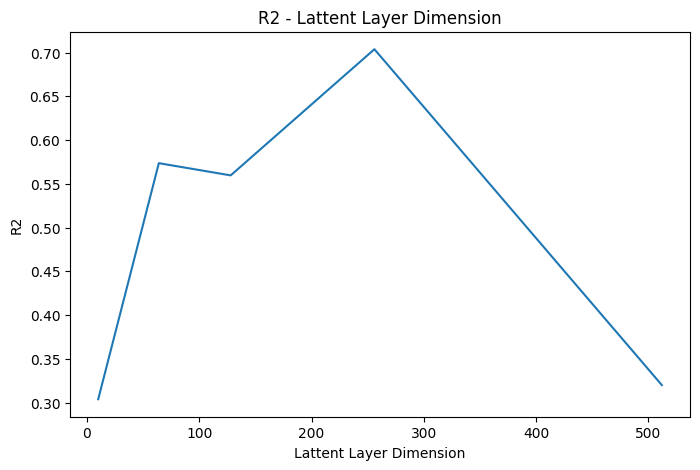

[10: 0.3038] [64: 0.5736] [128: 0.5596] [256: 0.7038] [512: 0.3200] 


In [15]:
evaluate_autoencoder(utils.Dataset_Select.MNIST.value, param_grid, create_simple_ae_as_sequence)

1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 453us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 397us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 447us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 451us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 499us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 473us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


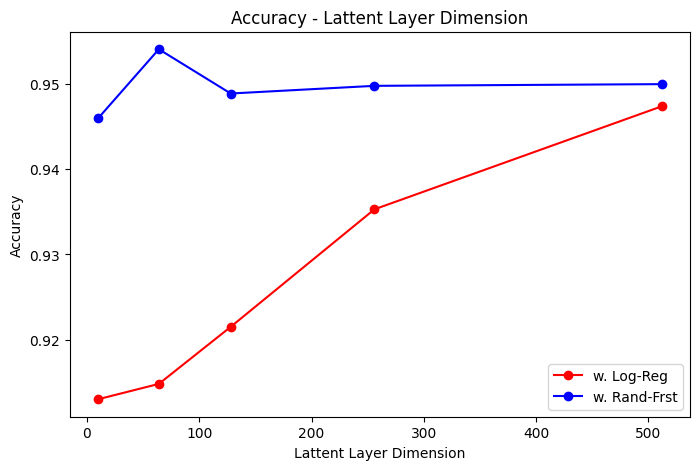

[10 -> w. Log-Reg: 0.9130, w. Rand-Frst: 0.9460]
[64 -> w. Log-Reg: 0.9148, w. Rand-Frst: 0.9541]
[128 -> w. Log-Reg: 0.9215, w. Rand-Frst: 0.9489]
[256 -> w. Log-Reg: 0.9353, w. Rand-Frst: 0.9498]
[512 -> w. Log-Reg: 0.9474, w. Rand-Frst: 0.9500]



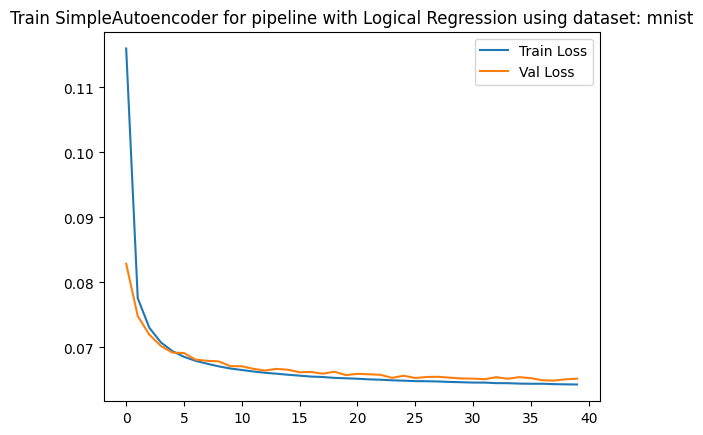

--- SimpleAutoencoder with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.98      0.98      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.93      0.94      0.94      1010
           4       0.94      0.95      0.94       982
           5       0.93      0.93      0.93       892
           6       0.94      0.95      0.95       958
           7       0.96      0.95      0.95      1028
           8       0.92      0.92      0.92       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



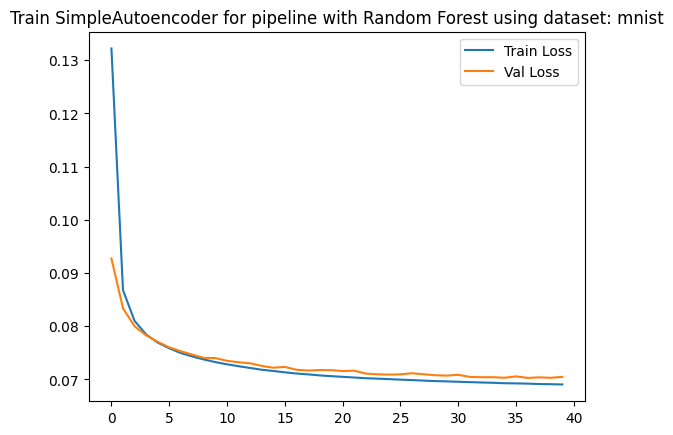

--- SimpleAutoencoder with Random Forest ---
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.94      0.95      1032
           3       0.92      0.95      0.93      1010
           4       0.96      0.96      0.96       982
           5       0.96      0.93      0.95       892
           6       0.96      0.97      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.93      0.94      0.93       974
           9       0.95      0.93      0.94      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [21]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.MNIST.value, SimpleAutoencoder, latent_dims, log_reg, rand_frst)

#### Fashion MNIST

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynow

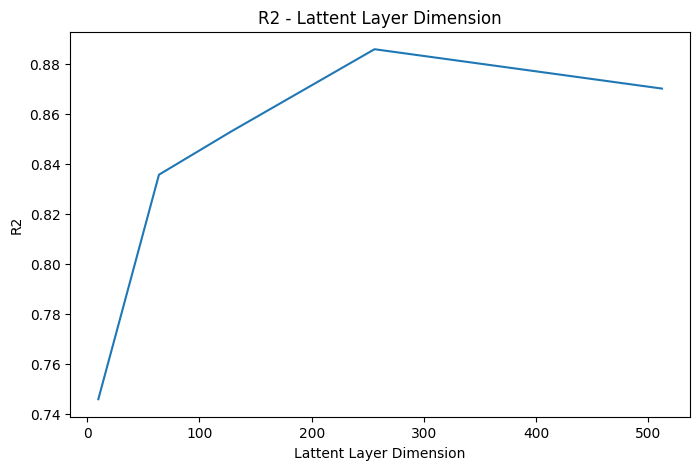

[10: 0.7459] [64: 0.8356] [128: 0.8528] [256: 0.8857] [512: 0.8700] 


In [19]:
evaluate_autoencoder(utils.Dataset_Select.F_MNIST.value, param_grid, create_simple_ae_as_sequence)

1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 471us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 465us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 582us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step


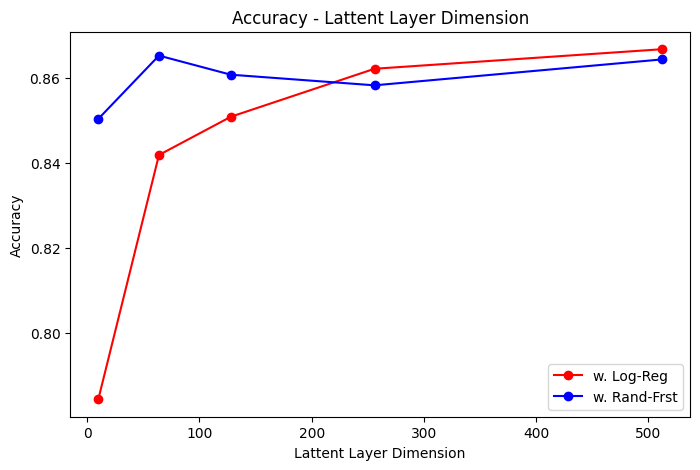

[10 -> w. Log-Reg: 0.7843, w. Rand-Frst: 0.8503]
[64 -> w. Log-Reg: 0.8418, w. Rand-Frst: 0.8652]
[128 -> w. Log-Reg: 0.8508, w. Rand-Frst: 0.8607]
[256 -> w. Log-Reg: 0.8621, w. Rand-Frst: 0.8582]
[512 -> w. Log-Reg: 0.8667, w. Rand-Frst: 0.8643]



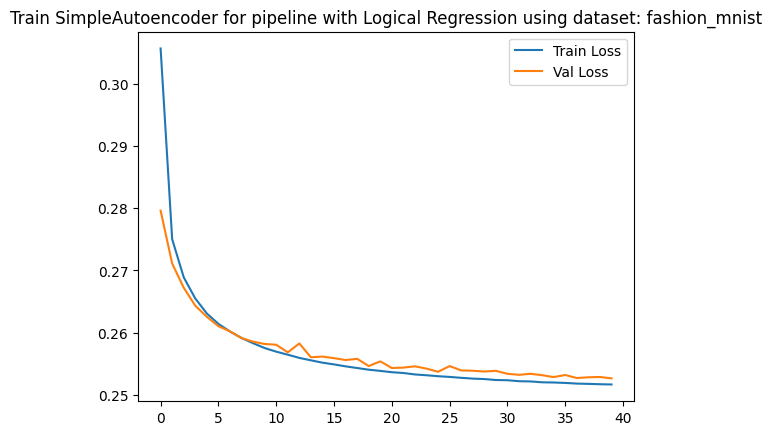

--- SimpleAutoencoder with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1000
           1       0.98      0.97      0.98      1000
           2       0.75      0.77      0.76      1000
           3       0.86      0.89      0.88      1000
           4       0.78      0.79      0.78      1000
           5       0.97      0.95      0.96      1000
           6       0.67      0.62      0.64      1000
           7       0.93      0.95      0.94      1000
           8       0.95      0.97      0.96      1000
           9       0.95      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



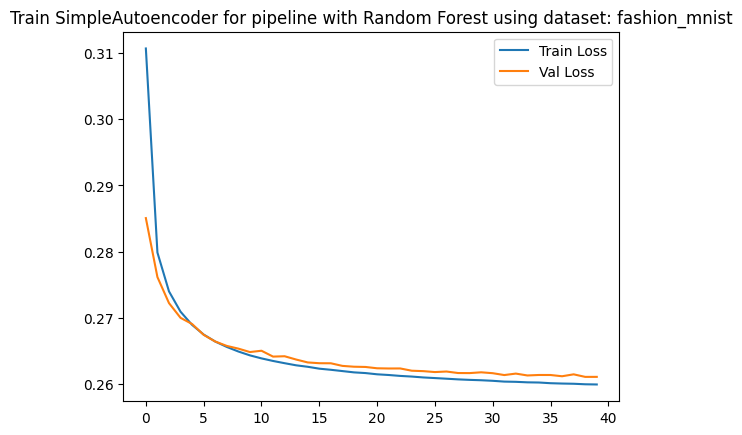

--- SimpleAutoencoder with Random Forest ---
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      1000
           1       1.00      0.95      0.97      1000
           2       0.75      0.80      0.78      1000
           3       0.86      0.90      0.88      1000
           4       0.77      0.79      0.78      1000
           5       0.97      0.92      0.94      1000
           6       0.71      0.58      0.64      1000
           7       0.90      0.94      0.92      1000
           8       0.94      0.97      0.95      1000
           9       0.93      0.95      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.86      0.87      0.86     10000



In [28]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.F_MNIST.value, SimpleAutoencoder, latent_dims, log_reg, rand_frst)

#### Kuzushiji MNIST

2025-01-05 02:29:16.656988: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-05 02:29:21.193868: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-05 02:29:21.993140: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, current

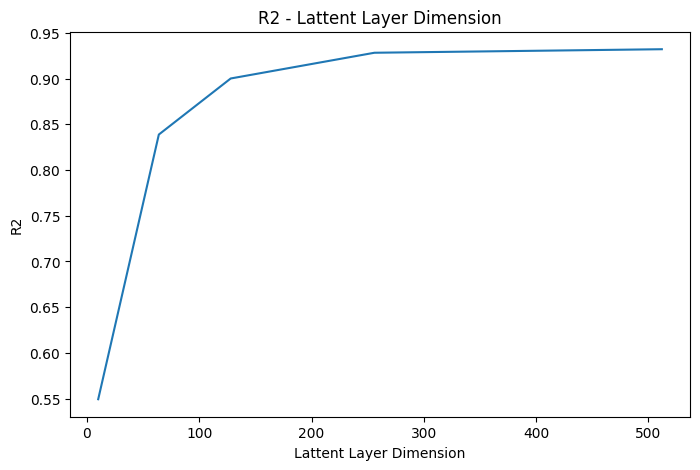

[10: 0.5494] [64: 0.8388] [128: 0.9001] [256: 0.9282] [512: 0.9321] 


In [22]:
evaluate_autoencoder(utils.Dataset_Select.K_MNIST.value, param_grid, create_simple_ae_as_sequence)

2025-01-05 23:21:26.855171: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 458us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 461us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 448us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step


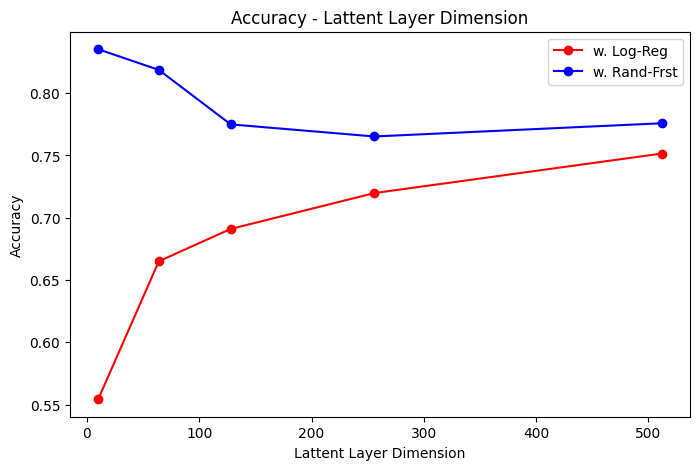

[10 -> w. Log-Reg: 0.5544, w. Rand-Frst: 0.8352]
[64 -> w. Log-Reg: 0.6651, w. Rand-Frst: 0.8186]
[128 -> w. Log-Reg: 0.6910, w. Rand-Frst: 0.7749]
[256 -> w. Log-Reg: 0.7198, w. Rand-Frst: 0.7652]
[512 -> w. Log-Reg: 0.7515, w. Rand-Frst: 0.7758]



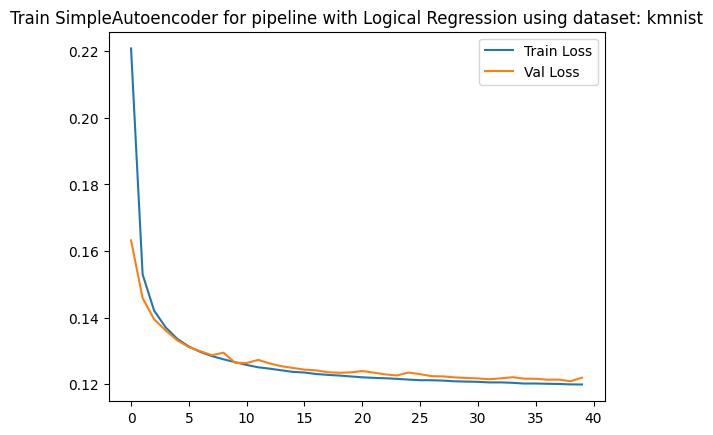

--- SimpleAutoencoder with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1000
           1       0.70      0.74      0.72      1000
           2       0.59      0.65      0.61      1000
           3       0.83      0.87      0.85      1000
           4       0.71      0.69      0.70      1000
           5       0.85      0.75      0.80      1000
           6       0.74      0.79      0.76      1000
           7       0.81      0.70      0.76      1000
           8       0.70      0.78      0.74      1000
           9       0.79      0.73      0.76      1000

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.76      0.75      0.75     10000



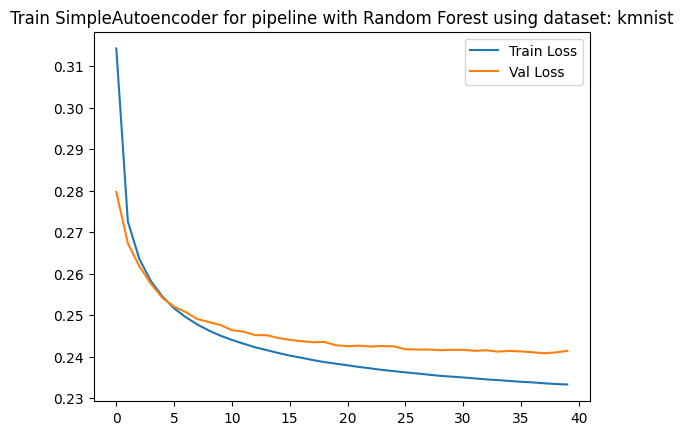

--- SimpleAutoencoder with Random Forest ---
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1000
           1       0.84      0.82      0.83      1000
           2       0.76      0.78      0.77      1000
           3       0.85      0.93      0.89      1000
           4       0.80      0.79      0.79      1000
           5       0.95      0.78      0.86      1000
           6       0.77      0.90      0.83      1000
           7       0.86      0.81      0.83      1000
           8       0.80      0.84      0.82      1000
           9       0.87      0.84      0.85      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [29]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.K_MNIST.value, SimpleAutoencoder, latent_dims, log_reg, rand_frst)

### Convolutional Autoencoder

In [22]:
class ConvAutoencoder(tf.keras.Model):
  def __init__(self, latent_dim):
    super(ConvAutoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=(784,)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(32, 3, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.MaxPooling2D(2, padding='same'),
            tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.MaxPooling2D(2, padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim),
            
        ]
    )
    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape((7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(64, 3, 2, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.Conv2DTranspose(32, 3, 2, activation=tf.nn.relu, padding='same'),
            tf.keras.layers.Conv2D(1, (3, 3), activation=tf.nn.sigmoid, padding='same'),
            tf.keras.layers.Reshape(target_shape=(784,))
        ]
    )

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
def create_conv_ae_as_sequence(latent_dim):
  model =  ConvAutoencoder(latent_dim)
  return tf.keras.Sequential([model.encoder, model.decoder])


#### MNIST

In [ ]:
evaluate_autoencoder(utils.Dataset_Select.MNIST.value, param_grid, create_conv_ae_as_sequence)

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynow

1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


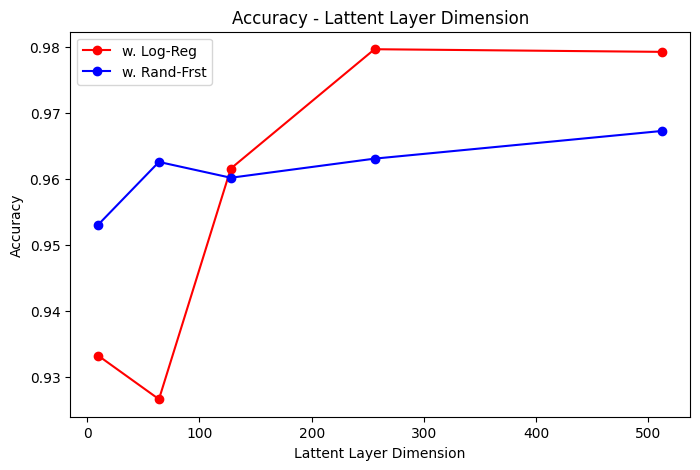

[10 -> w. Log-Reg: 0.9332, w. Rand-Frst: 0.9531]
[64 -> w. Log-Reg: 0.9266, w. Rand-Frst: 0.9626]
[128 -> w. Log-Reg: 0.9616, w. Rand-Frst: 0.9602]
[256 -> w. Log-Reg: 0.9797, w. Rand-Frst: 0.9631]
[512 -> w. Log-Reg: 0.9793, w. Rand-Frst: 0.9673]



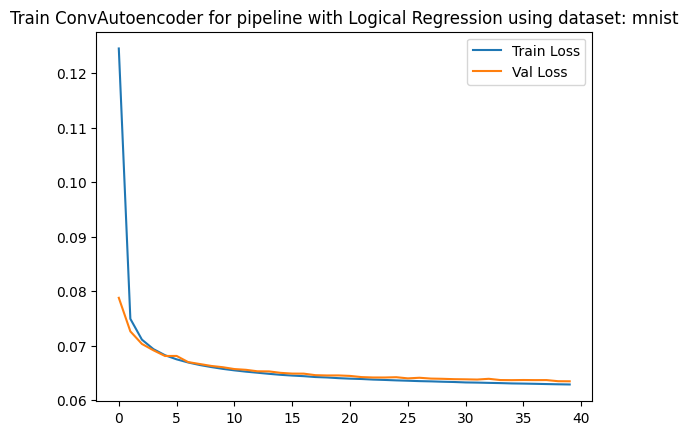

--- ConvAutoencoder with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.99      0.99       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



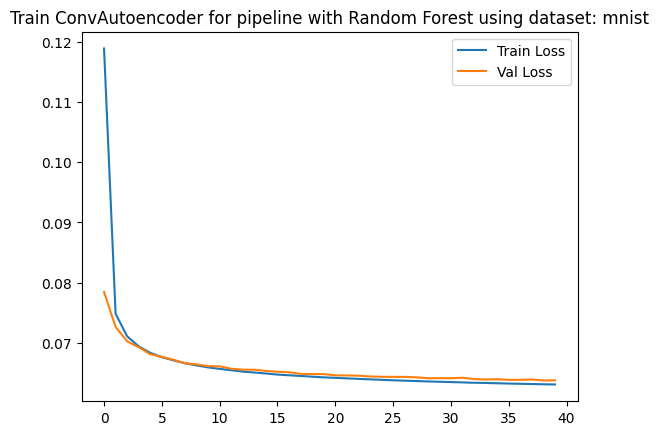

--- ConvAutoencoder with Random Forest ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.95      0.96      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.95      0.96       892
           6       0.97      0.98      0.98       958
           7       0.97      0.95      0.96      1028
           8       0.95      0.95      0.95       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [23]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.MNIST.value, ConvAutoencoder, latent_dims, log_reg, rand_frst)

#### Fashion MNIST

In [ ]:
evaluate_autoencoder(utils.Dataset_Select.F_MNIST.value, param_grid, create_conv_ae_as_sequence)

1608/1608 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


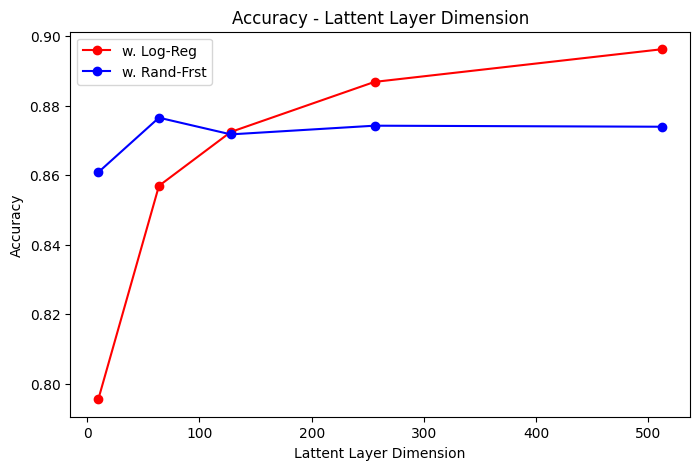

[10 -> w. Log-Reg: 0.7955, w. Rand-Frst: 0.8608]
[64 -> w. Log-Reg: 0.8569, w. Rand-Frst: 0.8765]
[128 -> w. Log-Reg: 0.8724, w. Rand-Frst: 0.8717]
[256 -> w. Log-Reg: 0.8868, w. Rand-Frst: 0.8742]
[512 -> w. Log-Reg: 0.8962, w. Rand-Frst: 0.8739]



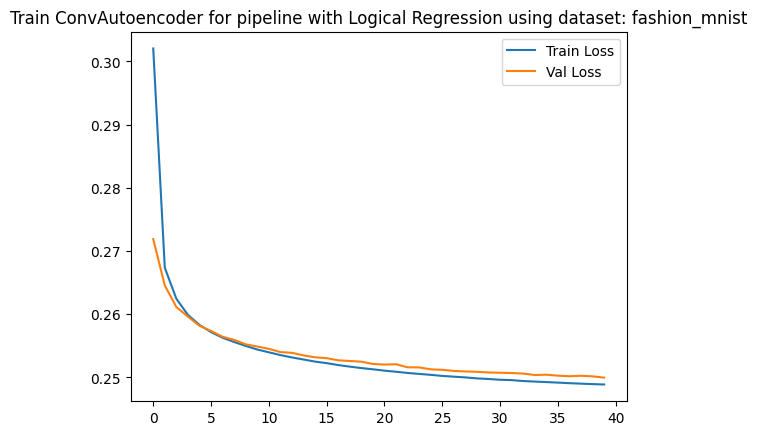

--- ConvAutoencoder with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.98      0.97      0.98      1000
           2       0.83      0.83      0.83      1000
           3       0.88      0.89      0.89      1000
           4       0.82      0.84      0.83      1000
           5       0.98      0.98      0.98      1000
           6       0.73      0.68      0.70      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.98      0.97      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



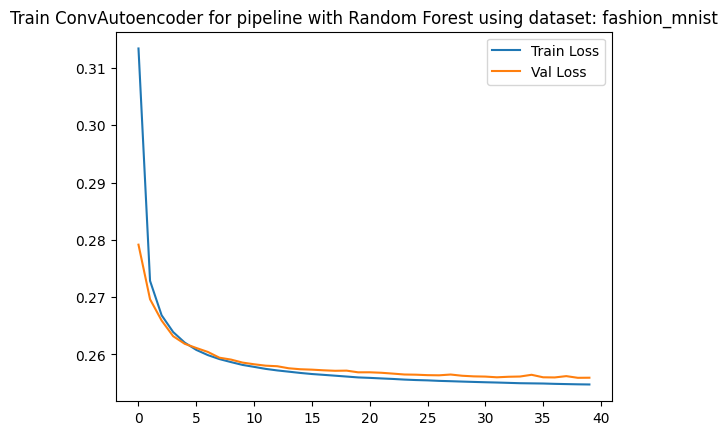

--- ConvAutoencoder with Random Forest ---
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.99      0.96      0.98      1000
           2       0.80      0.80      0.80      1000
           3       0.86      0.91      0.88      1000
           4       0.78      0.82      0.80      1000
           5       0.96      0.95      0.95      1000
           6       0.70      0.59      0.64      1000
           7       0.94      0.95      0.94      1000
           8       0.96      0.97      0.96      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.87      0.88      0.88     10000
weighted avg       0.87      0.88      0.88     10000



In [24]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.F_MNIST.value, ConvAutoencoder, latent_dims, log_reg, rand_frst)

#### Kuzushiji MNIST

In [ ]:
evaluate_autoencoder(utils.Dataset_Select.K_MNIST.value, param_grid, create_conv_ae_as_sequence)

2025-01-05 19:41:12.594293: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-01-05 19:41:17.725337: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-05 19:41:18.625760: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1608/1608 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


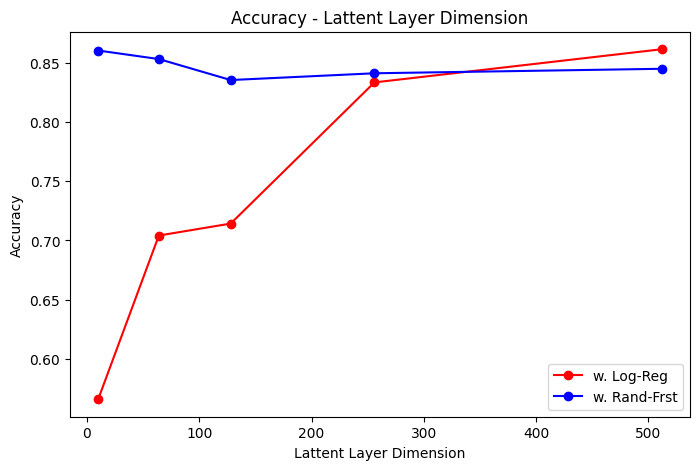

[10 -> w. Log-Reg: 0.5660, w. Rand-Frst: 0.8602]
[64 -> w. Log-Reg: 0.7041, w. Rand-Frst: 0.8530]
[128 -> w. Log-Reg: 0.7142, w. Rand-Frst: 0.8353]
[256 -> w. Log-Reg: 0.8333, w. Rand-Frst: 0.8410]
[512 -> w. Log-Reg: 0.8613, w. Rand-Frst: 0.8448]



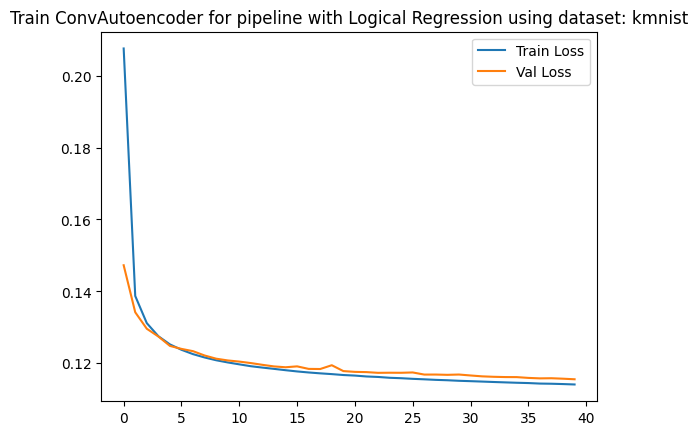

--- ConvAutoencoder with Logistic Regression ---
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1000
           1       0.87      0.86      0.87      1000
           2       0.78      0.77      0.77      1000
           3       0.89      0.92      0.90      1000
           4       0.81      0.81      0.81      1000
           5       0.92      0.85      0.88      1000
           6       0.81      0.89      0.85      1000
           7       0.89      0.86      0.87      1000
           8       0.86      0.90      0.88      1000
           9       0.89      0.88      0.88      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



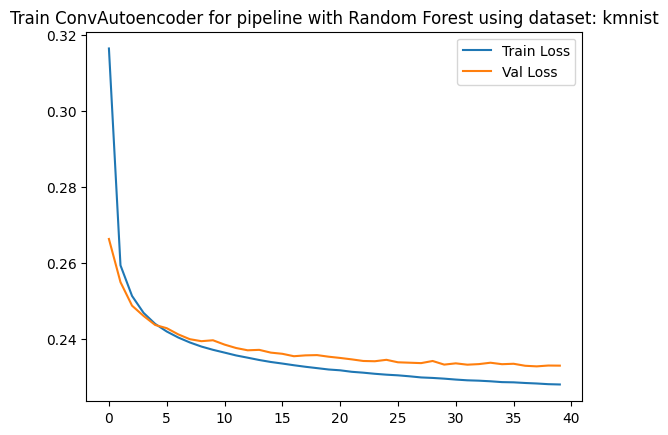

--- ConvAutoencoder with Random Forest ---
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1000
           1       0.86      0.86      0.86      1000
           2       0.78      0.81      0.80      1000
           3       0.85      0.94      0.89      1000
           4       0.82      0.83      0.83      1000
           5       0.95      0.82      0.88      1000
           6       0.83      0.91      0.87      1000
           7       0.89      0.84      0.87      1000
           8       0.86      0.86      0.86      1000
           9       0.89      0.85      0.87      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [25]:
log_reg = LogisticRegression(max_iter=1000, solver="newton-cg")
rand_frst = RandomForestClassifier(n_estimators=250, random_state=seed)
find_and_eval_best_encoder(utils.Dataset_Select.K_MNIST.value, ConvAutoencoder, latent_dims, log_reg, rand_frst)

### Podsumowanie

Poniższa tabela zbiera wyniki `accuracy` wszystkich modeli w jednym miejscu:

|                                       | MNIST | Fashion-MNIST | Kuzushiji-MNIST | Kuzushiji-49 |
|---------------------------------------|-------|---------------|-----------------|--------------|
| RBM                                   | 0.97  | 0.84          | 0.87            | 0.84         |
| DBN                                   | 0.97  | 0.83          | 0.86            |              |
| Autoenkoder z reg. log.               | 0.95  | 0.87          | 0.75            |              |
| Autoenkoder z lasem los.              | 0.95  | 0.87          | 0.84            |              |
| Autoenkoder konwolucyjny z reg. log.  | 0.98  | 0.90          | 0.86            |              |
| Autoenkoder konwolucyjny z lasem los. | 0.97  | 0.88          | 0.86            |              |

Latent 256:

==== LogisticRegression (ConvAE) ====
              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.80      0.83      0.82      1000
           3       0.88      0.91      0.90      1000
           4       0.80      0.81      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.72      0.66      0.69      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Accuracy (ConvAE + LogisticRegression): 0.8900

Latent 10:

==== LogisticRegression (ConvAE) ====
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      1000
           1       0.96      0.94      0.95      1000
           2       0.64      0.60      0.62      1000
           3       0.76      0.84      0.80      1000
           4       0.61      0.68      0.64      1000
           5       0.91      0.89      0.90      1000
           6       0.45      0.34      0.39      1000
           7       0.87      0.89      0.88      1000
           8       0.92      0.94      0.93      1000
           9       0.91      0.92      0.92      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000

Accuracy (ConvAE + LogisticRegression): 0.7834

Dense Latent 512:

```
==== LogisticRegression (ConvAE) ====
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.83      0.85      0.84      1000
           3       0.89      0.91      0.90      1000
           4       0.82      0.83      0.83      1000
           5       0.97      0.97      0.97      1000
           6       0.74      0.68      0.71      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy (ConvAE + LogisticRegression): 0.8979
```


No mod:

```
==== LogisticRegression (ConvAE) ====
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1000
           1       0.99      0.98      0.99      1000
           2       0.85      0.85      0.85      1000
           3       0.90      0.91      0.91      1000
           4       0.84      0.86      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.77      0.72      0.74      1000
           7       0.96      0.98      0.97      1000
           8       0.98      0.97      0.98      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000
```

In [22]:
conv_ae = ConvAutoencoder(256)

optimizer = tf.keras.optimizers.Adam(1e-3)
conv_ae.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy())

X_train, X_val, X_test, y_train, y_val, y_test = utils.get_dataset_for_ae(utils.Dataset_Select.F_MNIST.value, with_val=True)

In [23]:
conv_ae.fit(X_train, X_train,
                epochs=40,
                shuffle=True,
                batch_size=64,
                validation_data=(X_val, X_val))

Epoch 1/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - loss: 0.3652 - val_loss: 0.2757
Epoch 2/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - loss: 0.2726 - val_loss: 0.2672
Epoch 3/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - loss: 0.2653 - val_loss: 0.2635
Epoch 4/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.2625 - val_loss: 0.2612
Epoch 5/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.2604 - val_loss: 0.2598
Epoch 6/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.2595 - val_loss: 0.2588
Epoch 7/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - loss: 0.2574 - val_loss: 0.2583
Epoch 8/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.2572 - val_loss: 0.2571
Epoch 9/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.2560 - val_loss: 0.2566
Epoch 10/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.2554 - val_loss: 0.2563
Epoch 11/40
804/804 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - loss: 0.2548 - val_loss: 0.2557
Epoch 12/40
804/804 ━━━━━━━━━━

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrozenEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return self.encoder.predict(X)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

frozen_conv_ae = FrozenEncoder(encoder=conv_ae.encoder)

X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=utils.Dataset_Select.F_MNIST.value, with_val=False)

pipeline_log_reg = Pipeline([
    ('frozen_conv_ae', frozen_conv_ae),
    ('log_reg', LogisticRegression(max_iter=5000, solver="newton-cg"))
])

pipeline_log_reg.fit(X_train, y_train)

y_pred = pipeline_log_reg.predict(X_test)

print(classification_report(y_test, y_pred))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.82      0.83      0.82      1000
           3       0.88      0.91      0.90      1000
           4       0.80      0.82      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.70      0.64      0.67      1000
           7       0.94      0.96      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



3(256)
```
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1000
           1       0.98      0.98      0.98      1000
           2       0.81      0.82      0.82      1000
           3       0.88      0.91      0.89      1000
           4       0.80      0.82      0.81      1000
           5       0.97      0.97      0.97      1000
           6       0.69      0.64      0.67      1000
           7       0.94      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000
```
1(256)
```
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1000
           1       0.98      0.96      0.97      1000
           2       0.75      0.77      0.76      1000
           3       0.85      0.89      0.87      1000
           4       0.76      0.77      0.76      1000
           5       0.96      0.96      0.96      1000
           6       0.65      0.59      0.62      1000
           7       0.93      0.95      0.94      1000
           8       0.96      0.96      0.96      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000
```

In [271]:
import keras

from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

def evaluate_conv_autoencoder(dataset_name, params, create_plain_ae_fun, create_ae_from_params_fun):

    X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=dataset_name, with_val=False)

    keras_reg = KerasRegressor(
        model=create_plain_ae_fun,
        loss="binary_crossentropy",
        optimizer="adam",
        optimizer__learning_rate=0.001,
        model__latent_dim=10,
        verbose=False,
    )

    grid_search = GridSearchCV(keras_reg, params, refit=False, cv=7, n_jobs=-1)
    grid_search.fit(X_train, X_train)

    print(grid_search.best_score_, grid_search.best_params_)

    X_train_s, X_val_s, _, _, _, _ = utils.get_dataset_for_ae(dataset_name=dataset_name, with_val=True)

    ae = create_ae_from_params_fun(grid_search.best_params_)
    ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=grid_search.best_params_["optimizer__learning_rate"]), loss=keras.losses.BinaryCrossentropy)
    ae.fit(X_train_s, X_train_s,
                epochs=grid_search.best_params_["epochs"],
                shuffle=True,
                validation_data=(X_val_s, X_val_s))
    
    return ae

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, message=".*urllib3.*LibreSSL.*")

param_grid = {
    'model__latent_dim': [10, 64, 128, 192],
    'optimizer__learning_rate': [0.0001, 0.005, 0.001],
    'epochs': [40]
}

evaluated_conv_ae = evaluate_conv_autoencoder(utils.Dataset_Select.F_MNIST.value, param_grid, create_conv_ae_as_sequence, create_conv_ae_from_params)

/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynowe/labs/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mwardynski/Documents/ds/_semestr_9/uczenie_maszynow

## VAE

Nieudane próby

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(784)),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.Reshape(target_shape=(784)),
        ]
    )

In [ ]:
from tensorflow.keras import layers

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.prepare_encoder()
        self.decoder = self.prepare_decoder()

    def prepare_encoder(self):
        input_img = tf.keras.layers.Input(shape=(784,))
        x = tf.keras.layers.Reshape(target_shape=(28, 28, 1))(input_img)
        x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu')(x)
        x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(self.latent_dim + self.latent_dim)(x)
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        return  tf.keras.Model([input_img], [z_mean, z_log_var, z], name="encoder")

    def prepare_decoder(self):
        input = tf.keras.layers.Input(shape=(self.latent_dim,))
        x = tf.keras.layers.Dense(units=7*7*64, activation=tf.nn.relu)(input)
        x = tf.keras.layers.Reshape(target_shape=(7, 7, 64))(x)
        x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',activation='relu')(x)
        x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation=tf.nn.sigmoid)(x) 
        x = tf.keras.layers.Reshape(target_shape=(784,))(x)
        return  tf.keras.Model([input], [x], name="decoder")
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        self.add_loss(self.kl_loss(z_mean, z_log_var))
        return reconstructed

    def kl_loss(self, z_mean, z_log_var):
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        return tf.reduce_mean(kl_loss)

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.sampling_layer = Sampling()
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.Input(shape=(784,)),
                tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
                tf.keras.layers.Reshape(target_shape=(784,))
            ]
        )

    def call(self, inputs):
        z_mean, z_log_var = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        z = self.sampling_layer([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        self.add_loss(self.kl_loss(z_mean, z_log_var))
        return reconstructed


    def kl_loss(self, z_mean, z_log_var):
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        return tf.reduce_mean(kl_loss)

In [ ]:
vae = VAE(64)

optimizer = tf.keras.optimizers.Adam(1e-3)
vae.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy())

X_train, X_val, X_test, y_train, y_val, y_test = utils.get_dataset_for_ae(utils.Dataset_Select.MNIST.value, with_val=True)

In [ ]:
# X_train = X_train.reshape(-1, 784)
# X_val = X_val.reshape(-1, 784)

vae.fit(X_train, X_train,
                epochs=3,
                shuffle=True,
                validation_data=(X_val, X_val))

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class FrozenVEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, encoder):
        self.encoder = encoder

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        z_mean, z_log_var = tf.split(self.encoder.predict(X), num_or_size_splits=2, axis=1)
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

frozen_vencoder = FrozenEncoder(encoder=vae.encoder)

X_train, X_test, y_train, y_test = utils.get_dataset_for_ae(dataset_name=utils.Dataset_Select.MNIST.value, with_val=False)

pipeline_log_reg = Pipeline([
    ('frozen_vencoder', frozen_vencoder),
    ('log_reg', LogisticRegression(max_iter=2000, solver="newton-cg"))
])

pipeline_log_reg.fit(X_train, y_train)

y_pred = pipeline_log_reg.predict(X_test)

print(classification_report(y_test, y_pred))